In [1]:
import statsmodels.stats.power
import scipy.stats
import math
import numpy as np
import pylab
import seaborn as sns
import plotly.express as px
import pandas as pd

# The significance level

The point at which a business problem has most impact/context on a hypothesis test is at the choice of significance level. From an academic perspective, the value is often 0.05 or 0.1. These are useful stock values to take so that multiple hypothesis tests are somehow comparing 'apples with apples'. However, in the same way that a detector threshold would be tuned for a specific installation or business problem, so must a significance level. 

The choice of significance level is based on acceptable levels of Type I (by significance level) and Type II errors (by statistical power). This is similar to the threshold setting one might have in a detector when using a ROC to balance nuisance alarm rate versus probability of detection.

### Type I and Type II errors

A hypothesis test is formed from a null hypothesis, and a an alternative hypothesis. Based on a calculation, the null hypothesis may be rejected in favour of the alternate.

What if the calculation shows that the null hypothesis should be rejected, but in reality the null hypothesis is true? What is the calculation shows that the null hypothesis should ne accepted, when in reality the null hypothesis is a poor hypothesis to make in the presence of the alternate hypothesis?

These can be quantified as errors:
- Type I error - the null hypothesis is incorrectly rejected in favour of the alternate hypothesis. This has a probability $\alpha$ of occuring
- Type II error - the null hypothesis is incorrectly accepted. This has a probability $\beta$ of occuring.

<img src="type-1-and-2-errors.jpg" width="400">

The _statistical power_ of a hypothesis test is defined as: power $ = 1 - \beta$.

When the null hypothesis is actually true, the distribution assumed by the null hypothesis, and used in the calculation of the test statistic will be the true distribution. Therefore, when thw null hypothesis is actually true, the probabiity of the test statistic being in the rejectable region (which would lead to rejecting the null hypothesis) is precisely the significance level of the test (i.e. $\alpha = $ significance level).

### Statistical power

Calculation of statistical power depends on some prior knowledge of what happens in the case of an alternative hypothesis. For the calculation of a Type I error, knowledge of what happens in the case of a null hypothesis is given by the candidate distribution for the null hypothesis. Given how a significance test is often phrased, this information is not usually available for the alternative hypothesis, e.g.
- $H_0: \mu = 5$ (and the distribution is Normal, with standard deviation obtained from the data)
- $H_1: \mu > 5$

In [2]:
mu0 = 5
sigma = 2  # assume that the data comes from a distribution with standard deviation 2...
nobs = 20  # ... so that the standard deviation of the test stat is 2 / math.sqrt(20)
alpha = 0.1  # significance level of test

The null hypothesis assumes a distribution for the test statistic as $X_0 \sim N\left(\mu_0, \frac{\sigma}{\sqrt{n}}\right)$, where $n$ is the number of samples in the test statistic. The alternative hypothesis dictates a one tailed (larger) test. The significance can the converted to an x value, which represents $x_0$ such that $\alpha = P(X_0>x_0)$.

In [3]:
x0 = scipy.stats.norm.isf(alpha, loc=mu0, scale=sigma/math.sqrt(nobs))
print(f"x0 = {x0}")

x0 = 5.5731272834458006


Since the statistical power/Type II error describes the case where the null hypothesis is actually false, calculation of the probability of Type II errors requires prior knowledge of the actual distribution of the data.

For an alternative case, one can explore a case where the actual distribution has $\mu_1 = 6$ (this is just a possible case pulled out of thin air). The test statistic would then actually have a distribution $X_1 \sim N\left(\mu_1, \frac{\sigma}{\sqrt{n}}\right)$. 

In [4]:
mu1=6  # this is what we'll take the actual distribution to be

One can then compute the statistical power $= P(X_1 > x_0)$. Note that this is taking the _actual_ distribution, and comparing it with the x-values obtained from _incorrect_ distribution assumed by the null hypothesis.

In [5]:
p = scipy.stats.norm.sf(x0, loc=mu1, scale=sigma/math.sqrt(nobs))
print(f"statistical power = {p}")
print(f"probability of Type II error = {1-p}")

statistical power = 0.8300888470917936
probability of Type II error = 0.16991115290820635


This result could also be directly obtained from Python's statsmodels

In [6]:
ratio = 0.0  # set to zero to force a 1-sample test in the power calc
effect_size = (mu1-mu0)/sigma  # represents knowledge of the actual distribution compared to the 
                               # candidate distribution assumed by the null hypothesis
p = statsmodels.stats.power.NormalIndPower(ddof=0).power(effect_size, nobs, alpha, ratio, 'larger')
print(f"statistical power = {p}")

statistical power = 0.8300888470917935


Statsmodels has methods for calculating [statistical powers](https://www.statsmodels.org/dev/stats.html#power-and-sample-size-calculations) for various tests. The prior knowledge for the actual distribution is fed in with the "effect_size" variable.

In the graphs below, "es" is the "effect size".

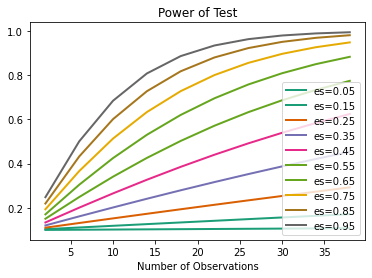

In [7]:
array = np.arange(0.1, 2.1, 0.2)
_ = statsmodels.stats.power.NormalIndPower(ddof=0).plot_power('nobs', nobs * array, effect_size * array, alpha)

The power of the test increases for larger effect sizes (since a larger effect size means $\mu_1$ is much larger than $\mu_0$), and as the number of observations increases (since the standard deviations of the candidate and true distributions become smaller).

### Choice of significance level

The choice of significance level is based on the acceptable levels for Type I and Type II errors. Directly changing the significance level to bring down one error means increasing the other error. Bringing both of these down to acceptable levels may involve increasing the number of samples used in the test.

In [12]:
# wrapper function for getting the type 2 probability
def get_prob_type_2(effect_size, nobs, alpha):
    return 1 - statsmodels.stats.power.NormalIndPower(ddof=0).power(effect_size, nobs, alpha, ratio, 'larger')

In [13]:
# use the wrapper function to build up a data frame for easy plotting
alphas = np.arange(0.001, 0.3, 0.001)
nobs_list = np.arange(10, 70, 10)
data_list = [
    {
        "probability type II error": get_prob_type_2(effect_size, y, x),
        "probability type I error a.k.a. significance level": x,
        "number of observations": y
    } for x in alphas for y in nobs_list
]
df = pd.DataFrame(data_list)
df["statistical power"] = 1.0 - df["probability type II error"]

In [17]:
# plotly for nice interactive plots in a Jupyter notebook
px.line(df, 
    x="probability type I error a.k.a. significance level", 
    y="probability type II error", 
    color="number of observations",
    title=f"error curves with effect size = {effect_size}"
)

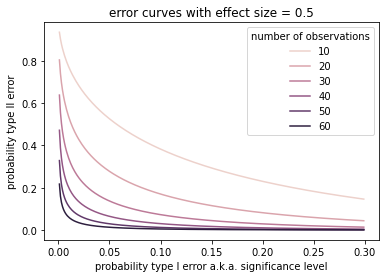

In [15]:
# seaborn for static plotting and in-repo-web-rendering
_ = sns.lineplot(
    x="probability type I error a.k.a. significance level", 
    y="probability type II error", 
    hue="number of observations",
    data=df
).set(
    title=f"error curves with effect size = {effect_size}"
)

In practice, the significance level chosen will depend on the acceptable balance between a type I and type II error for the business problem. For instance, with 10 observations, one could choose a significance level of 0.1, so that P(Type I) = 0.1, and P(Type II) = 0.38. If that type II probability is too high for the business problem, then perhaps a significance level of 0.2 is better, where P(Type I) = 0.2, and P(Type II) = 0.23.

This analysis may also influence the number of samples points collected for the test. If the probability of each error neads to be below a certain number, then more test observations may need to be collected.

The above analysis does assume a particular effect size. The smaller the effect size a statistician may wish to pick up, the more delicate/sensitive the test will have to be (which will have the effect of increasing the probability of errors). The actual analysis for significance level will also need to consider what effect size should be sensibly considered.